In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
from matplotlib.gridspec import GridSpec
from juliacall import Main as jl
import copy, pickle, io
from PIL import Image

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
jl.seval('using Pkg; Pkg.activate("/Users/eiadhamwi/.julia/environments/scibmad")')

  Activating project at `~/.julia/environments/scibmad`


In [3]:
jl.include("nsrl.jl")
nsrl = jl.nsrl

In [4]:
def sobol_uniform(n, d):
    sampler = qmc.Sobol(d, scramble=False).fast_forward(1)
    return sampler.random(n)
    
def sobol_normals(n, d, eps=1e-12):
    U = sobol_uniform(n, d)
    # Clamp to avoid 0 or 1, which would lead to ±inf in inverse CDF
    U = np.clip(U, eps, 1 - eps)
    Z = norm.ppf(U)  # Elementwise inverse CDF (aka "probit")
    return Z

In [5]:
N = 50_000
Z = sobol_normals(N, 4)
Zx = Z[:, 0:2]
Zy = Z[:, 2:4]

epsilon_a = 7.7e-6
epsilon_b = 7.7e-6

beta_a = 7
beta_b = 8
alpha_a = -0.3
alpha_b = -0.8

Mx = np.array([[np.sqrt(beta_a), 0],
               [-alpha_a / np.sqrt(beta_a), 1/np.sqrt(beta_a)]])
My = np.array([[np.sqrt(beta_b), 0],
               [-alpha_b / np.sqrt(beta_b), 1/np.sqrt(beta_b)]])

coords_x = np.sqrt(epsilon_a) * (Zx @ Mx.T)
coords_y = np.sqrt(epsilon_b) * (Zy @ My.T)
coords_z = np.zeros((N, 2))

coords = np.hstack([coords_x, coords_y, coords_z])

# Pass coords back into Julia to construct Bunch
jl_coords = jl.Array(coords)

# Assume Bunch, Ta, R etc. are defined in nsrl.jl
b0 = jl.Bunch(jl_coords, species=jl.Ta, R_ref=jl.R)
bunch = jl.deepcopy(b0)

In [6]:
import helpers

/Users/eiadhamwi/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


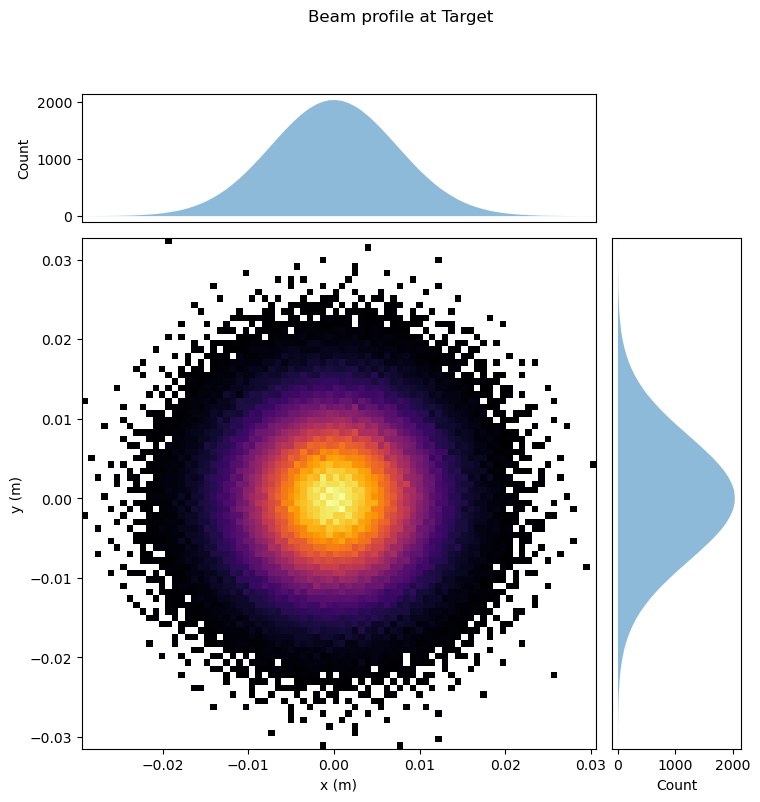

In [7]:
helpers.hist(
    b0, 
    xlims=None, ylims=None,
    nx=80, ny=80, 
);

In [8]:
# Track the bunch through the beamline
jl.track_b(bunch, nsrl);

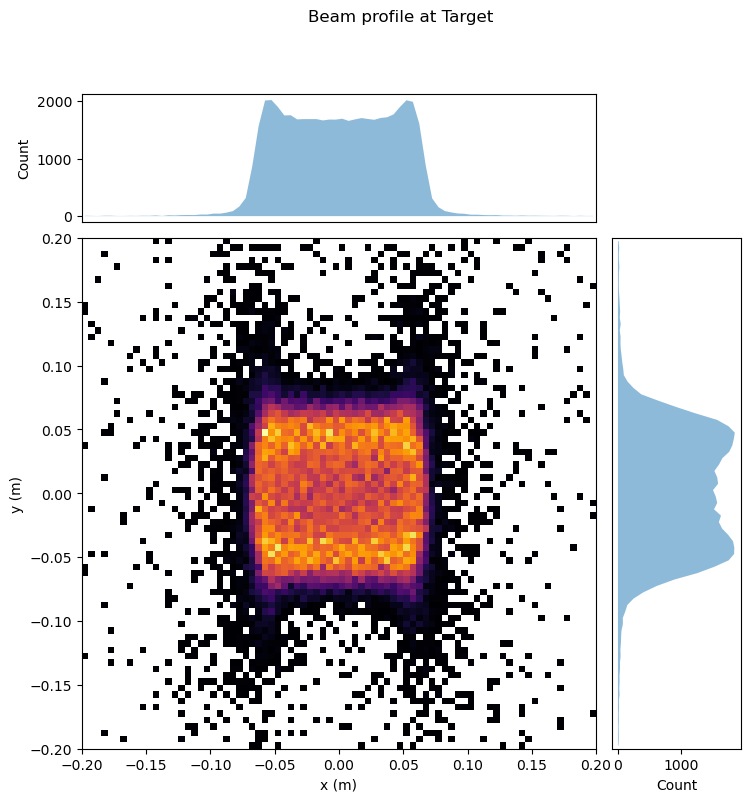

In [9]:
# Visualize tracked bunch
p0 = helpers.hist(
    bunch, 
    xlims=(-0.2,0.2), ylims=(-0.2,0.2),
    nx=80, ny=80
)

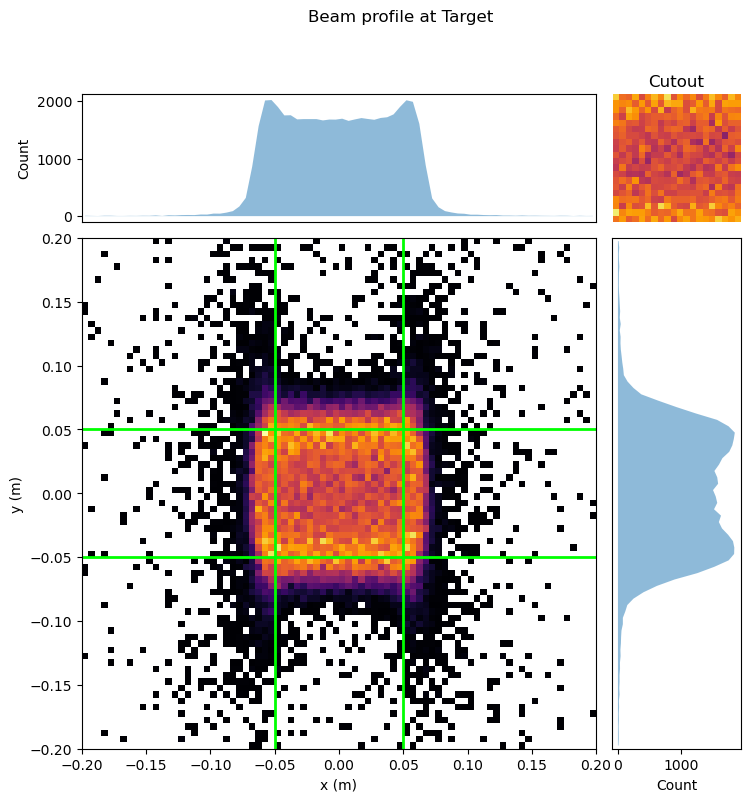

In [10]:
helpers.hist(
    bunch, 
    nx=80, ny=80,
    h=0.05, v=0.05,
    cutout=True
);

In [11]:
cutout = helpers.hist(
    bunch, 
    nx=80, ny=80,
    h=0.05, v=0.05,
    cutout=True,
    make_plot=False
)

In [13]:
cutout_hist = cutout['cutout']
n_particles = cutout['n_total']

print(f"Portion of total: {cutout_hist.sum() / n_particles * 100:.3f} %")
print(f"Mean: {np.mean(cutout_hist):.3f}")
print(f"STD: {np.std(cutout_hist):.3f}")
print(f"Max: {np.max(cutout_hist):.3f}  Min: {np.min(cutout_hist):.3f}")

Portion of total: 47.666 %
Mean: 59.583
STD: 9.245
Max: 89.000  Min: 36.000


In [14]:
def box_merit(cutout):
    box_data, n_total = cutout['cutout'], cutout['n_total']

    arr = box_data.flatten()
    arr = arr[~np.isnan(arr)]
    frac = arr.sum() / n_total
    uniformity = np.std(arr) / np.mean(arr) if arr.size > 0 else np.nan
    return frac, uniformity

In [15]:
box_merit(cutout)

(np.float64(0.47666), np.float64(0.1551658855340292))

In [16]:
Q3 = jl.Q3
Q4 = jl.Q4

In [17]:
# Parameter scan: vary box size
# Scan different Q3, Q4 settings and box sizes to optimize beam uniformity
import time

# Initialize result array
merit_size = np.zeros((21, 21, 3, 2))

print("Starting parameter scan over box sizes...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    
    Q3.Bn1 = q3_b1
    
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        
        Q4.Bn1 = q4_b1
        
        try:
            bunch_tmp = jl.deepcopy(b0)
            jl.track_b(bunch_tmp, nsrl)
    
            for k, _size in enumerate(np.arange(0.05, 0.08, 0.01)):
                
                cutout_tmp = helpers.hist(bunch_tmp, cutout=True, make_plot=False)
                merit_size[i, j, k, :] = box_merit(cutout_tmp)
                
        except Exception as e:
            merit_size[i, j, k, :] = np.nan
            
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Scan complete! Elapsed time: {elapsed:.1f} seconds")

SyntaxError: unmatched ')' (158898386.py, line 26)

/var/folders/fk/b4j2dkwn5090v4msn0vr3q3h0000gn/T/ipykernel_36611/3354495627.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


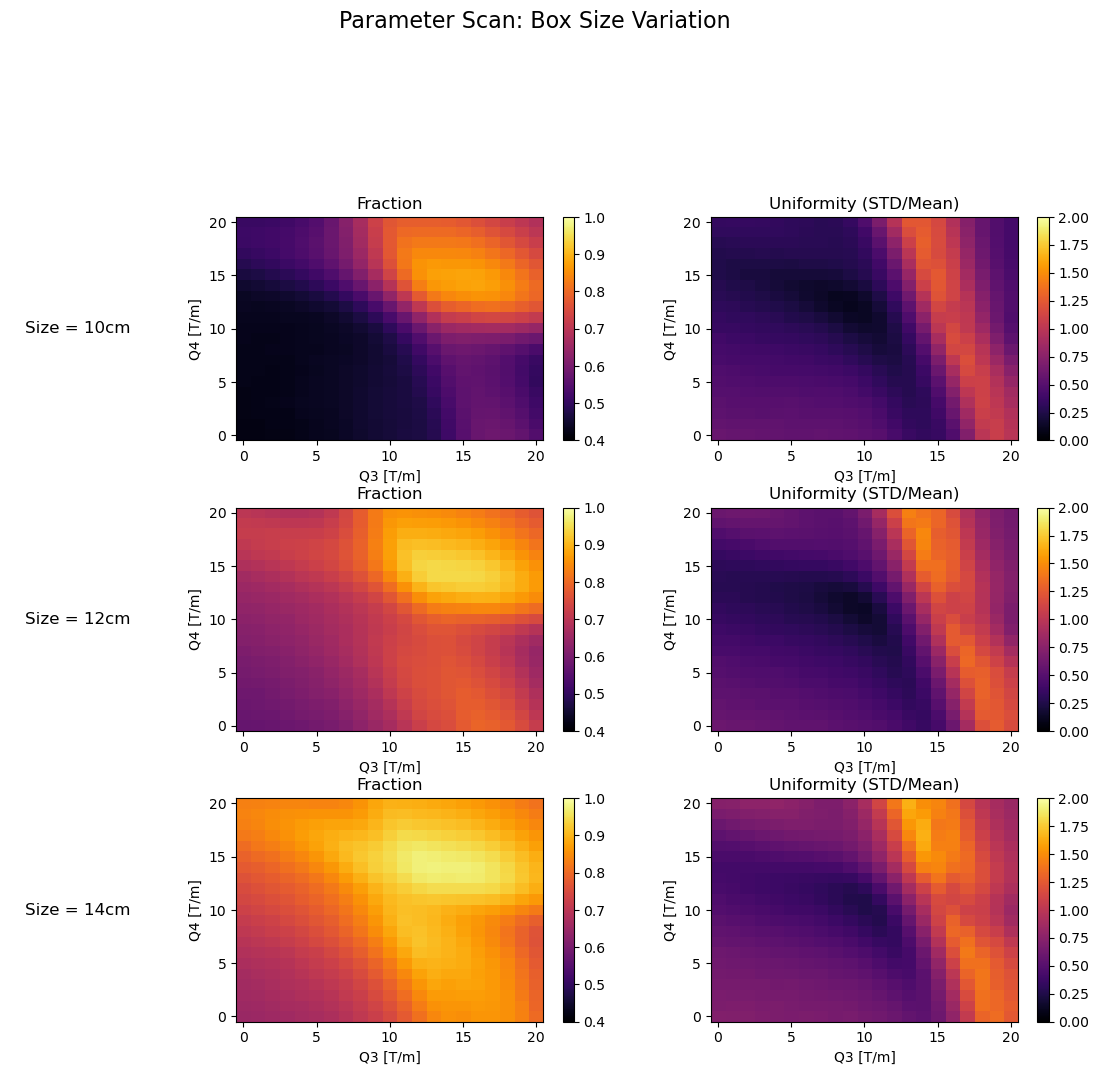

In [16]:
# Visualize results: create heatmaps for all 5 box sizes
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(3):
    size_cm = 5 + k  # 5cm to 9cm
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Size = {2*size_cm}cm', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_size[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                         vmin=0.4, vmax=1.0, cmap='inferno')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_size[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                         vmin=0.0, vmax=2.0, cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Box Size Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Parameter scan: vary octupole strength
# Scan Q3, Q4, and octupole settings
merit_oct = np.zeros((21, 21, 5, 2))

# Get references to Julia objects
O1 = jl.O1
O2 = jl.O2

print("Starting octupole parameter scan...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    Q3.Bn1 = q3_b1
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        Q4.Bn1 = q4_b1
        for k, o_b3 in enumerate(np.arange(1250, 2251, 250)):
            O1.Bn3 = -o_b3
            O2.Bn3 = o_b3
            
            try:
                # Track bunch
                bunch_tmp = jl.deepcopy(b0)
                jl.track_b(bunch_tmp, nsrl)
                # Compute histogram
                hist_data = hist(bunch_tmp, nx=80, ny=80, make_plot=False)
                # Compute merit
                frac, uniform = box_merit(box(hist_data, h=0.05, v=0.05))
                merit_oct[i, j, k, 0] = frac
                merit_oct[i, j, k, 1] = uniform
            except Exception as e:
                print(f"Error at Q3={q3_b1}, Q4={q4_b1}, O.Bn3={o_b3}: {e}")
                merit_oct[i, j, k, :] = np.nan
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Octupole scan complete! Elapsed time: {elapsed:.1f} seconds")

In [ ]:
# Visualize octupole scan results
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(5):
    bn3_val = 1250 + 250 * k
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Bn3 = {bn3_val}\n[T/m³]', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_oct[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='infero')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_oct[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Octupole Strength Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [18]:
O1 = jl.O1
O2 = jl.O2

In [260]:
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.sequential.neldermead import NelderMeadGenerator
from xopt.generators.bayesian.turbo import OptimizeTurboController

from xopt import Xopt
import math
import pandas as pd
import xopt

In [217]:
vocs = VOCS(
    variables={
        "x1": [ 2.0,  4.0], 
        "x2": [-4.0, -2.0], 
        "x3": [1250., 2250.]
    },
    objectives={"f": "MINIMIZE"},
)

def merit_function(x):
    Q3.Bn1 =  x["x1"]
    Q4.Bn1 =  x["x2"]
    O1.Bn3 = -x["x3"]
    O2.Bn3 =  x["x3"]
    
    # Track bunch
    bunch_tmp = jl.deepcopy(b0)
    jl.track_b(bunch_tmp, nsrl)
    
    # Compute objectives
    cutout_tmp = helpers.hist(bunch_tmp, h=0.07, v=0.07, cutout=True, make_plot=False)
    frac, uniform = box_merit(cutout_tmp)
    
    # Merit function: minimize uniformity and penalize low fraction
    cost = uniform + np.exp(25 * (0.70 - frac))

    return {"f": cost}

In [244]:
evaluator = Evaluator(function=merit_function)

generator = ExpectedImprovementGenerator(vocs=vocs, turbo_controller="optimize")
generator.gp_constructor.use_low_noise_prior = True

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

_tmp = {
    "x1" :  [3.0, 2.0, 2.0, 4.0, 4.0],
    "x2" : [-3.0, -4.0, -2.0, -2.0, -4.0],
    "x3" : [1.75e3, 1.75e3, 1.75e3, 1.75e3, 1.75e3]
}

X.evaluate_data(_tmp)

,x1,x2,x3,f,xopt_runtime,xopt_error
0,3.0,-3.0,1750.0,0.261510,0.367962,False
1,2.0,-4.0,1750.0,82455.056353,0.166019,False
2,2.0,-2.0,1750.0,5.127069,0.132813,False
3,4.0,-2.0,1750.0,15.131757,0.133935,False
4,4.0,-4.0,1750.0,13.038510,0.132593,False


In [253]:
for i in range(100):
    X.step()

In [254]:
best_ind = np.where(X.data["f"] == X.data["f"].min())[0]
best_f = X.data.loc[best_ind]
best_f

,x1,x2,x3,f,xopt_runtime,xopt_error
171,2.992651,-2.950022,1599.833824,0.211035,0.138693,False


In [257]:
X.evaluate_data(X.generator.get_optimum())

,x1,x2,x3,f,xopt_runtime,xopt_error
0,2.823504,-2.477799,1298.922651,0.49212,0.157054,False


In [226]:
X.evaluate_data({
    "x1":2.96481,
    "x2":-2.950054,
    "x3":1466.837819
})

,x1,x2,x3,f,xopt_runtime,xopt_error
0,2.96481,-2.950054,1466.837819,0.199743,0.171005,False



Applying optimized parameters:
Q3.Bn1 = 2.992651
Q4.Bn1 = -2.950022
O1.Bn3 = -1599.833824
O2.Bn3 = 1599.833824

Optimized merit:
Fraction in box: 0.4781
Uniformity (STD/Mean): 0.1381


Text(0.5, 0, 'Count')

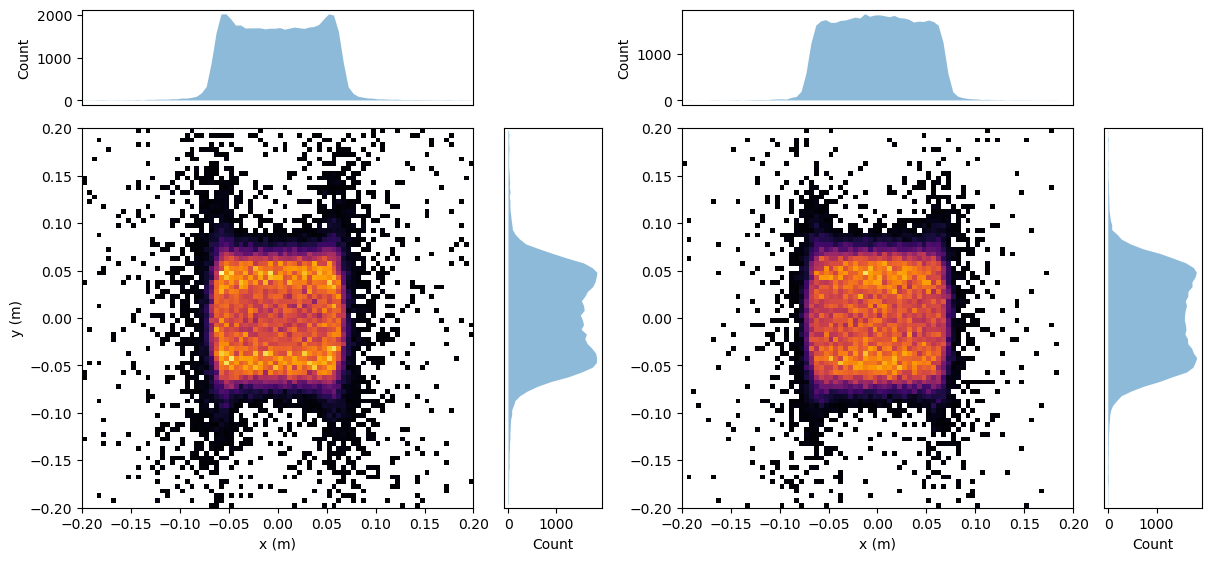

In [258]:
# Apply optimized parameters and visualize results
jl.Q3.Bn1 = best_f["x1"].iloc[0]
jl.Q4.Bn1 = best_f["x2"].iloc[0]
jl.O1.Bn3 =-best_f["x3"].iloc[0]
jl.O2.Bn3 = best_f["x3"].iloc[0]

print(f"\nApplying optimized parameters:")
print(f"Q3.Bn1 = {jl.Q3.Bn1:.6f}")
print(f"Q4.Bn1 = {jl.Q4.Bn1:.6f}")
print(f"O1.Bn3 = {jl.O1.Bn3:.6f}")
print(f"O2.Bn3 = {jl.O2.Bn3:.6f}")

# Track with optimized parameters
b_opt = jl.deepcopy(b0)
jl.track_b(b_opt, jl.nsrl)

# Compute merit
cutout_tmp = helpers.hist(b_opt, nx=80, ny=80, make_plot=False, cutout=True)
frac_opt, uniform_opt = box_merit(cutout_tmp)
print(f"\nOptimized merit:")
print(f"Fraction in box: {frac_opt:.4f}")
print(f"Uniformity (STD/Mean): {uniform_opt:.4f}")

# 1) Reuse your function's "data-only" path
A = helpers.hist(bunch, make_plot=False)
B = helpers.hist(b_opt, make_plot=False)

# 2) Centers + marginals (from the returned arrays)
x_edges, y_edges = A["x_edges"], A["y_edges"]  # same for B by construction
x_cent = 0.5 * (x_edges[:-1] + x_edges[1:])
y_cent = 0.5 * (y_edges[:-1] + y_edges[1:])

Ax_marg = np.nansum(A["hist"], axis=1)  # sum over y (rows)
Ay_marg = np.nansum(A["hist"], axis=0)  # sum over x (cols)
Bx_marg = np.nansum(B["hist"], axis=1)
By_marg = np.nansum(B["hist"], axis=0)

# 3) Shared color scale
vmin, vmax = 0.0, np.nanmax([np.nanmax(A["hist"]), np.nanmax(B["hist"])])

# 4) Layout: 2 rows × 4 cols → [A_main|A_right|B_main|B_right] with top marginals above mains
fig = plt.figure(figsize=(12, 5.5), constrained_layout=True)
gs  = fig.add_gridspec(2, 4,
                       width_ratios=[0.8, 0.2, 0.8, 0.2],
                       height_ratios=[0.2, 0.8],
                       wspace=0.05, hspace=0.05)

# --- A ---
axA_top   = fig.add_subplot(gs[0,0])
axA_main  = fig.add_subplot(gs[1,0])
axA_right = fig.add_subplot(gs[1,1])

axA_top.fill_between(x_cent, Ax_marg, alpha=0.5)
axA_top.set_xlim((-0.2,0.2)); axA_top.set_xticks([]); axA_top.set_ylabel("Count")

mA = axA_main.pcolormesh(x_edges, y_edges, A["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axA_main.set_xlabel("x (m)"); axA_main.set_ylabel("y (m)")
axA_main.set_aspect('auto')

axA_right.fill_betweenx(y_cent, Ay_marg, alpha=0.5)
axA_right.set_ylim((-0.2,0.2)); axA_right.set_yticks([]); axA_right.set_xlabel("Count")
axA_main.tick_params(labelleft=True, labelbottom=True)


# --- B (share x/y with A for perfect alignment) ---
axB_top   = fig.add_subplot(gs[0,2])
axB_main  = fig.add_subplot(gs[1,2])
axB_right = fig.add_subplot(gs[1,3])


axB_top.fill_between(x_cent, Bx_marg, alpha=0.5)
axB_top.set_xlim((-0.2,0.2)); axB_top.set_xticks([]); axB_top.set_ylabel("Count")

mB = axB_main.pcolormesh(x_edges, y_edges, B["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axB_main.set_xlabel("x (m)")
axB_main.set_aspect('auto')
axB_main.tick_params(labelleft=True, labelbottom=True)

axB_right.fill_betweenx(y_cent, By_marg, alpha=0.5)
axB_right.set_ylim((-0.2,0.2)); axB_right.set_yticks([]); axB_right.set_xlabel("Count")